In [1]:
import gc
import os
import torch
import warnings
import numpy as np
import pandas as pd
import back_testing as bt
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
from lib.utils import load_pickle
from lib.algos.base import BaseConfig
from lib.arfnn import SimpleGenerator

gc.collect()
warnings.filterwarnings("ignore")

In [2]:
def estimate_VaR_ES(result_df, cl):
    VaR_array = result_df.apply(
        lambda col: np.percentile(col[pd.to_numeric(col, errors='coerce').notna()], cl)
        if col[pd.to_numeric(col, errors='coerce').notna()].size > 0 else np.nan,
        axis=0
    )
    mask = result_df.values[:, VaR_array.notna()] <= np.array(VaR_array.dropna())
    ES_array = np.where(mask, result_df.values[:, VaR_array.notna()], np.nan)
    ES_array = np.nanmean(ES_array, axis=0)
    return round(np.nanmean(VaR_array), 4), round(np.mean(ES_array), 4)


def simulate_rand_day(momentum_12m):
    random_idx = pd.to_datetime(np.random.choice(momentum_12m.index))
    rand_momentum_12m = momentum_12m.loc[random_idx:, :]
    weights = bt.dual_momentum_strategy(rand_momentum_12m)
    local_result = pd.DataFrame()
    local_result = bt.return_Table(weights, returns, local_result, True, 'Neutral', True, False)
    return local_result


def simulate_rand_company(price_df):
    random_cols = np.random.choice(price_df.columns, size=10, replace=False)
    df_ = price_df[random_cols]
    returns = bt.get_momentum(df_, 1)
    momentum_12m = bt.get_momentum(df_, 12)
    weights = bt.dual_momentum_strategy(momentum_12m)
    local_result = pd.DataFrame()
    local_result = bt.return_Table(weights, returns, local_result, True, 'Neutral', True, False)
    return local_result


def get_dataset_configuration(df_0):
    df_1 = df_0.dropna(axis=0)
    df_2 = df_1.pct_change().applymap(lambda x: np.log1p(x)).dropna()
    return df_2, np.array(df_2.mean()), np.array(df_2.std())

In [3]:
price_df = pd.read_csv('./data/sp500.csv')
price_df.set_index('datadate', inplace=True)
price_df.index = pd.to_datetime(price_df.index, format='%Y-%m-%d')

idx_df = pd.read_csv('./data/GSPC.csv', index_col='Date')
idx_df = idx_df.pct_change().apply(lambda x: np.log1p(x)).dropna()
idx_df.index = pd.to_datetime(idx_df.index, format='%Y-%m-%d')

df_ = price_df[['AAPL', 'DIS', 'XOM', 'INTC', 'MSFT', 'AMZN', 'NVDA', 'CRM', 'GOOGL', 'TSLA']]
r_log_real, mean, std = get_dataset_configuration(df_)
returns = bt.get_momentum(df_, 1)
momentum_12m = bt.get_momentum(df_, 12)

In [4]:
rand_day = False
if rand_day:
    results = Parallel(n_jobs=8)(delayed(simulate_rand_day)(momentum_12m) for _ in tqdm(range(1000)))
    result_df = pd.concat(results, axis=1)
    print(estimate_VaR_ES(result_df, 5))

In [5]:
rand_company = False
if rand_company:
    results = Parallel(n_jobs=8)(delayed(simulate_rand_company)(price_df) for _ in tqdm(range(1000)))
    result_df = pd.concat(results, axis=1)
    print(estimate_VaR_ES(result_df, 5))

In [6]:
MC = True
if MC:
    n_simulations = 10000
    n_assets = returns.shape[1]

    mu = returns.mean().values
    cov = returns.cov().values
    L = np.linalg.cholesky(cov)

    Z = np.random.normal(size=(n_simulations, n_assets))
    correlated_returns = Z @ L.T

    simulated_returns = correlated_returns + mu.reshape(1, -1)
    MC_ret_df = pd.DataFrame(simulated_returns, columns=returns.columns)

    initial_price = df_.dropna(axis=0).iloc[0, :]
    MC_pri_df = initial_price * (1 + MC_ret_df).cumprod(axis=0)

    fake_returns = bt.get_momentum(MC_pri_df, 1)
    fake_momentum_12m = bt.get_momentum(MC_pri_df, 12)
    result_df = pd.DataFrame()
    weights = bt.dual_momentum_strategy(fake_momentum_12m)
    result_df = bt.return_Table(weights, fake_returns, result_df, True, 'Neutral', True, False)

    print(estimate_VaR_ES(result_df, 5))

(-0.0289, -0.0378)


In [7]:
sig = True
if sig:
    device = 'cpu'
    experiment_dir = './numerical_results/VAR/stock/seed=0/SigCWGAN'
    base_config = BaseConfig(device=device)
    p, q = base_config.p, base_config.q
    x_real = load_pickle(os.path.join(os.path.dirname(experiment_dir), 'x_real_test.torch')).to(device)
    x_past, x_future = x_real[:, :p], x_real[:, p:p + q]
    dim = x_real.shape[-1]
    G_weights = load_pickle(os.path.join(experiment_dir, 'G_weights.torch'))
    G = SimpleGenerator(dim * p, dim, 3 * (50,), dim).to(device)
    G.load_state_dict(G_weights)

    with torch.no_grad():
        x_fake = G.sample(8000, x_past[0:1])

    x_fake = x_fake.squeeze()
    x_fake = x_fake.cpu().detach().numpy()
    r_log_fake = x_fake * std + mean
    r_simple_fake = np.exp(r_log_fake) - 1  # shape: (10, T)

    sig_ret_df = pd.DataFrame(r_simple_fake, columns=returns.columns)

    initial_price = df_.dropna(axis=0).iloc[0, :]
    sig_pri_df = initial_price * (1 + sig_ret_df).cumprod(axis=0)

    fake_returns = bt.get_momentum(sig_pri_df, 1)
    fake_momentum_12m = bt.get_momentum(sig_pri_df, 12)
    result_df = pd.DataFrame()
    weights = bt.dual_momentum_strategy(fake_momentum_12m)
    result_df = bt.return_Table(weights, fake_returns, result_df, True, 'Neutral', True, False)

    print(estimate_VaR_ES(result_df, 5))

(-0.0318, -0.0715)


In [9]:
G

SimpleGenerator(
  (network): ResFNN(
    (network): Sequential(
      (0): ResidualBlock(
        (linear): Linear(in_features=40, out_features=50, bias=True)
        (activation): PReLU(num_parameters=1)
      )
      (1): ResidualBlock(
        (linear): Linear(in_features=50, out_features=50, bias=True)
        (activation): PReLU(num_parameters=1)
      )
      (2): ResidualBlock(
        (linear): Linear(in_features=50, out_features=50, bias=True)
        (activation): PReLU(num_parameters=1)
      )
      (3): Linear(in_features=50, out_features=10, bias=True)
    )
  )
)

In [10]:
import matplotlib.pyplot as plt

def plot_generator_weights(generator):
    for name, module in generator.named_modules():
        if isinstance(module, torch.nn.Linear):
            weights = module.weight.data.cpu().numpy().flatten()

            plt.figure(figsize=(6, 3))
            plt.hist(weights, bins=50, alpha=0.7)
            plt.title(f'Weight Distribution - {name}')
            plt.xlabel('Weight value')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.tight_layout()
            plt.show()


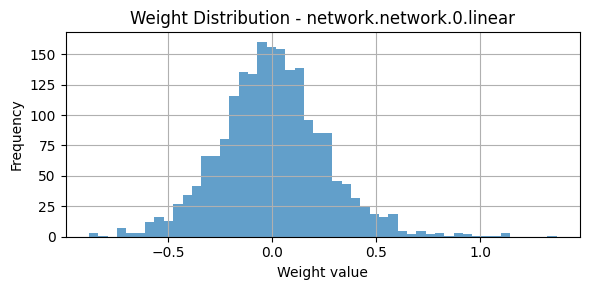

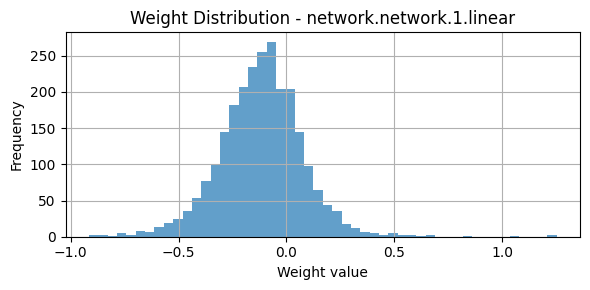

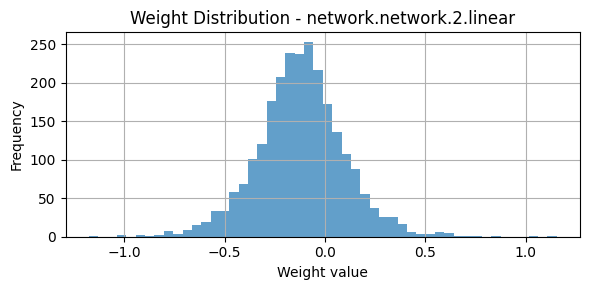

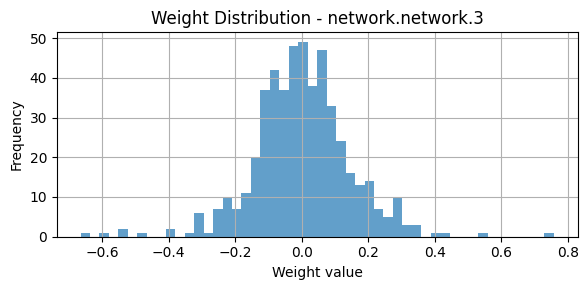

In [11]:
plot_generator_weights(G)

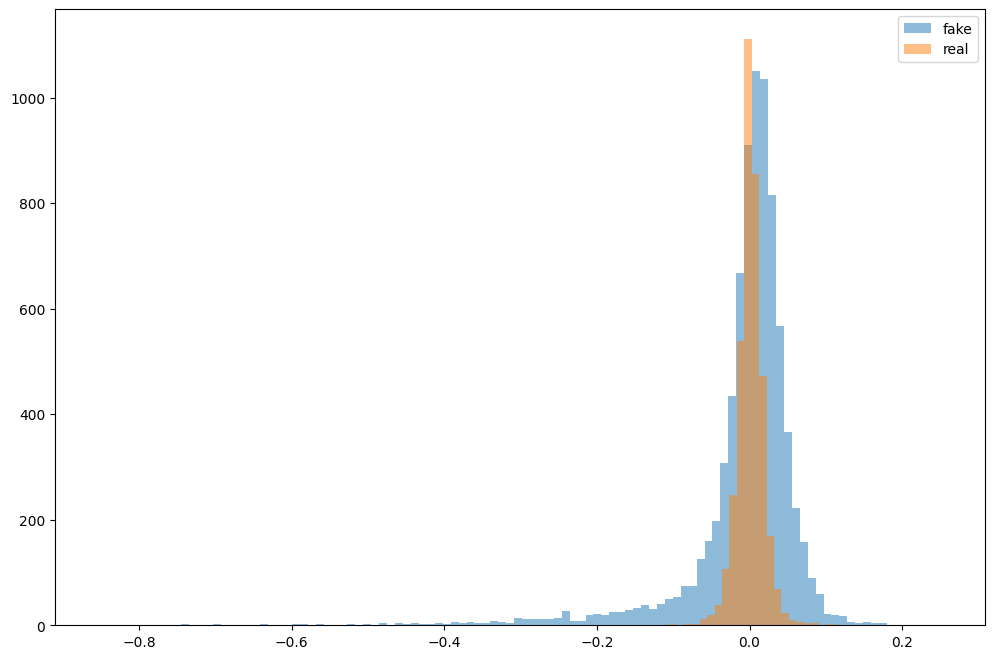

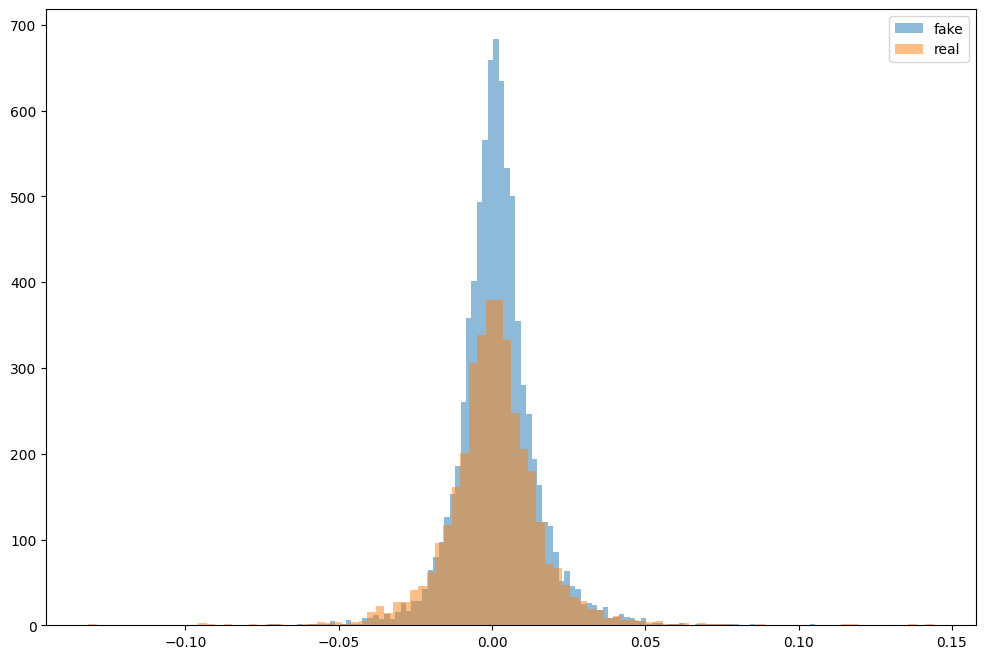

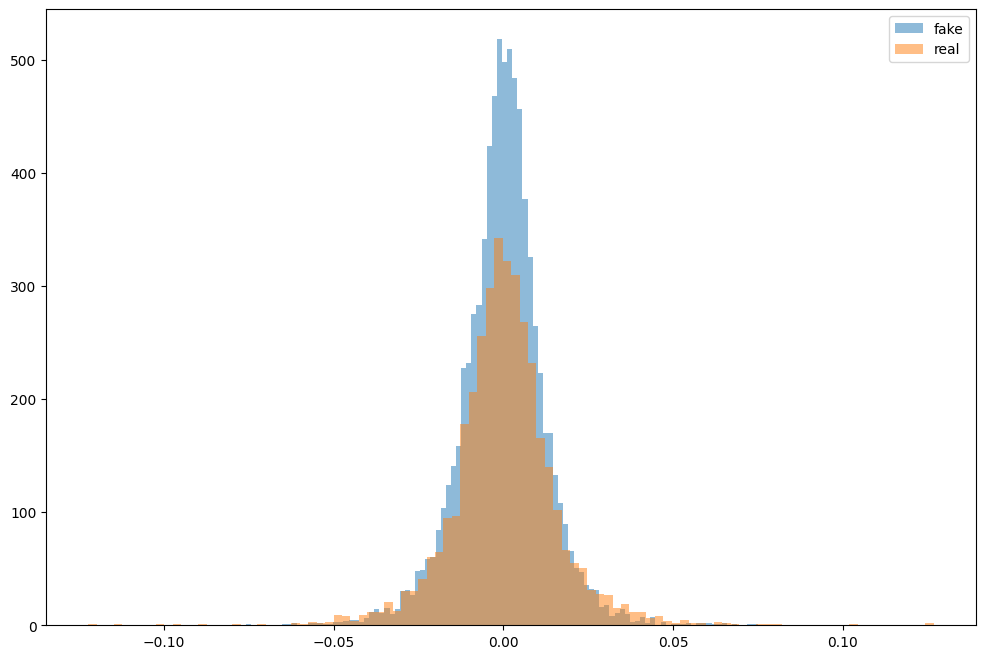

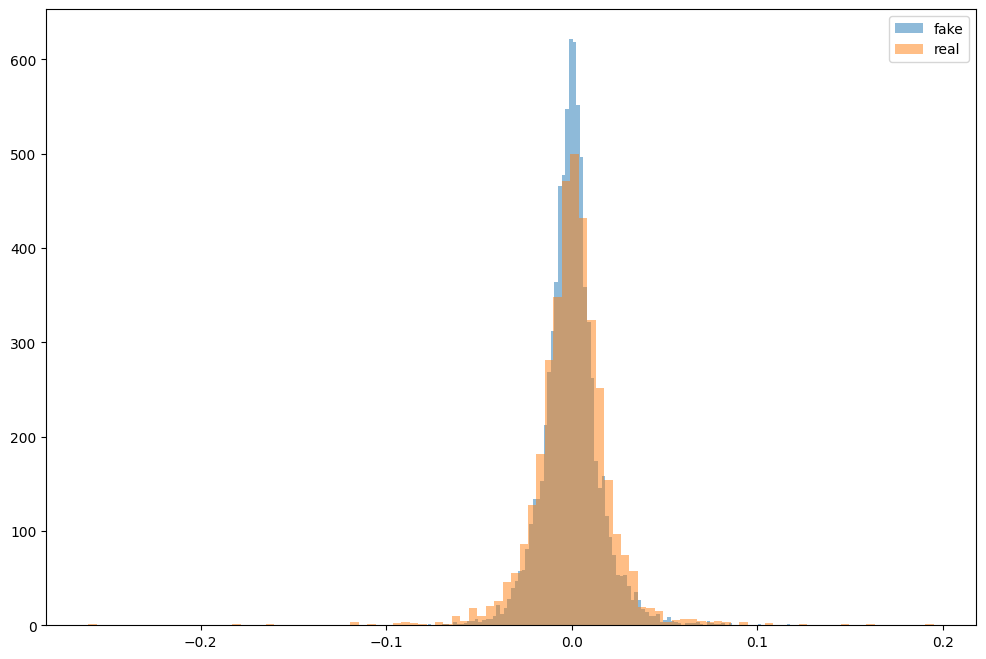

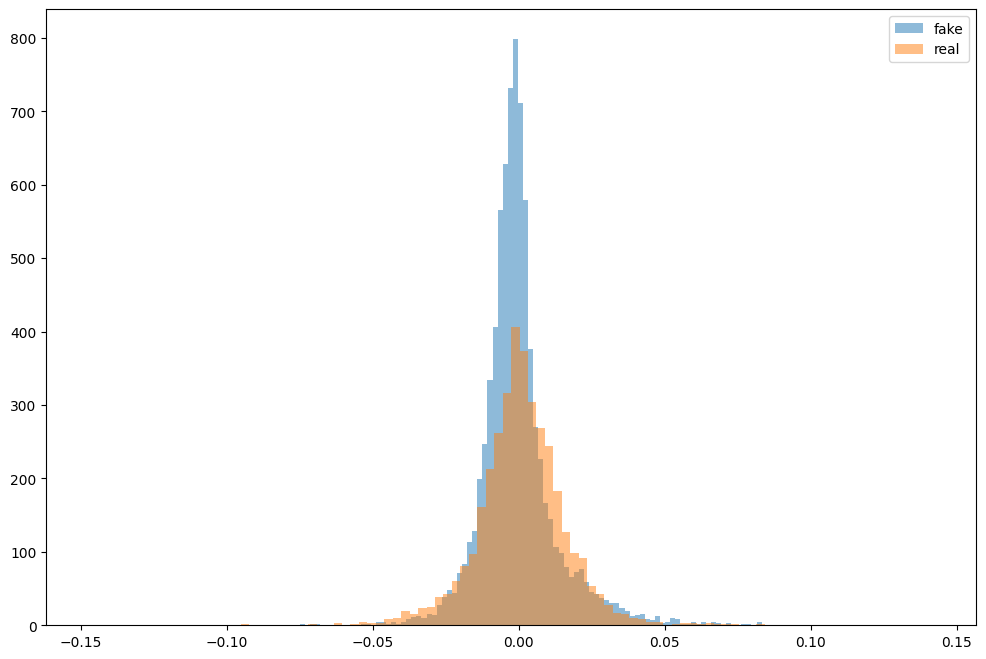

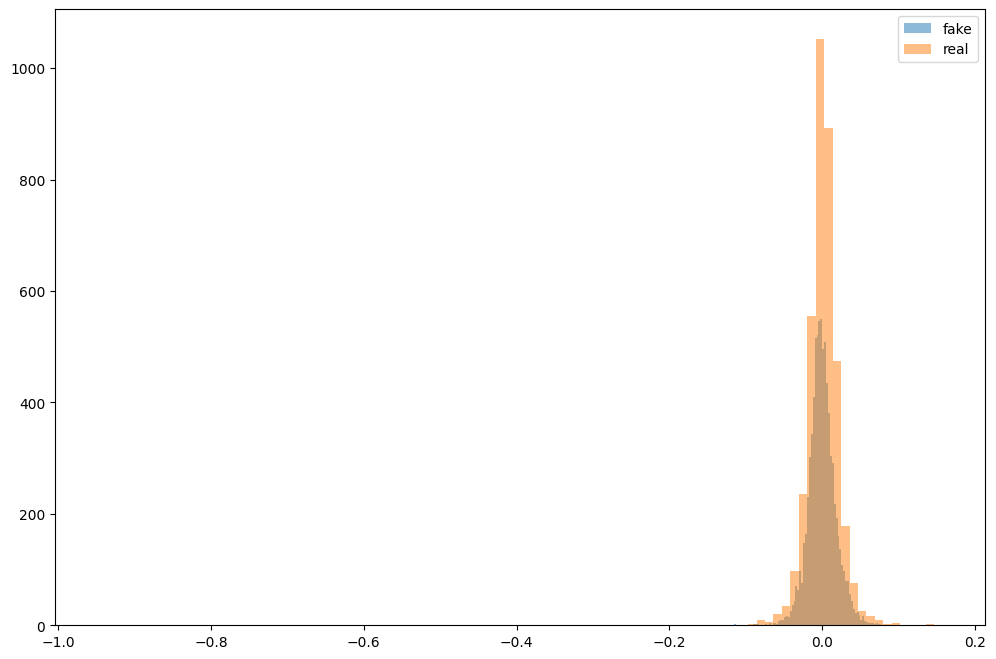

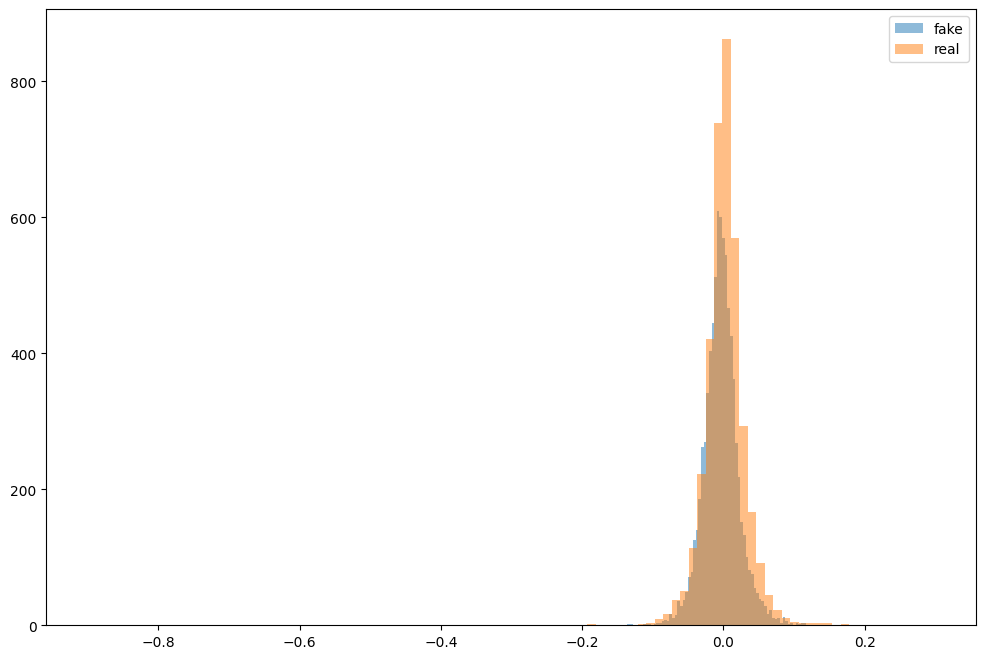

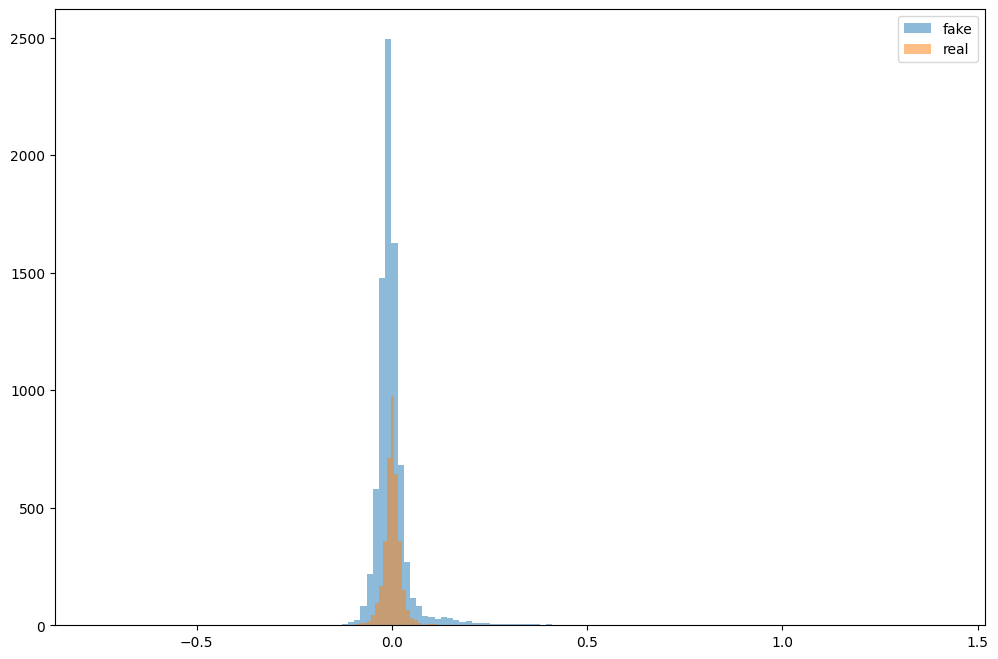

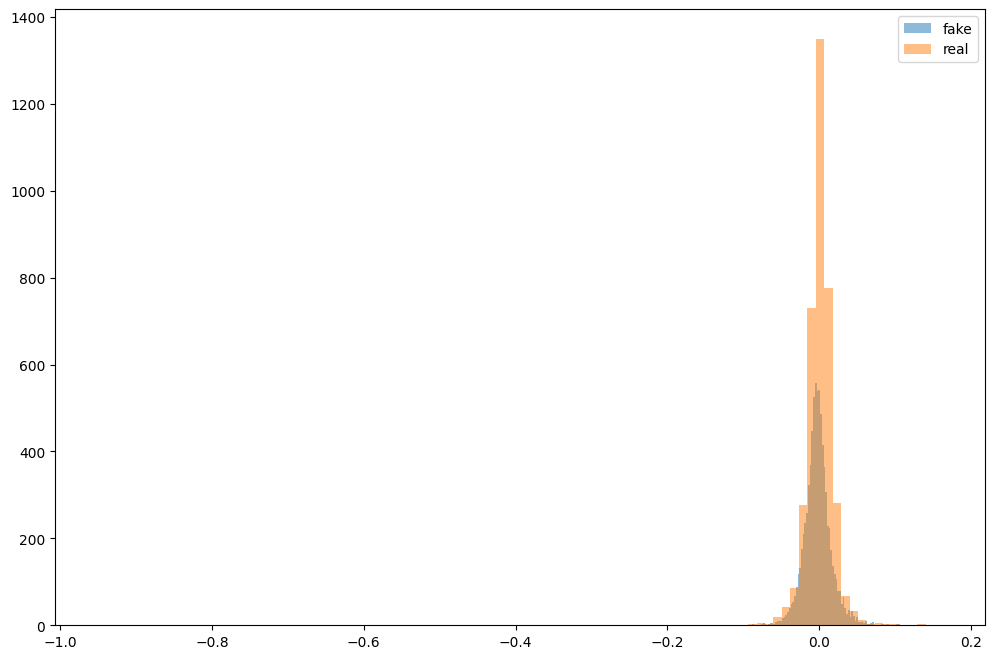

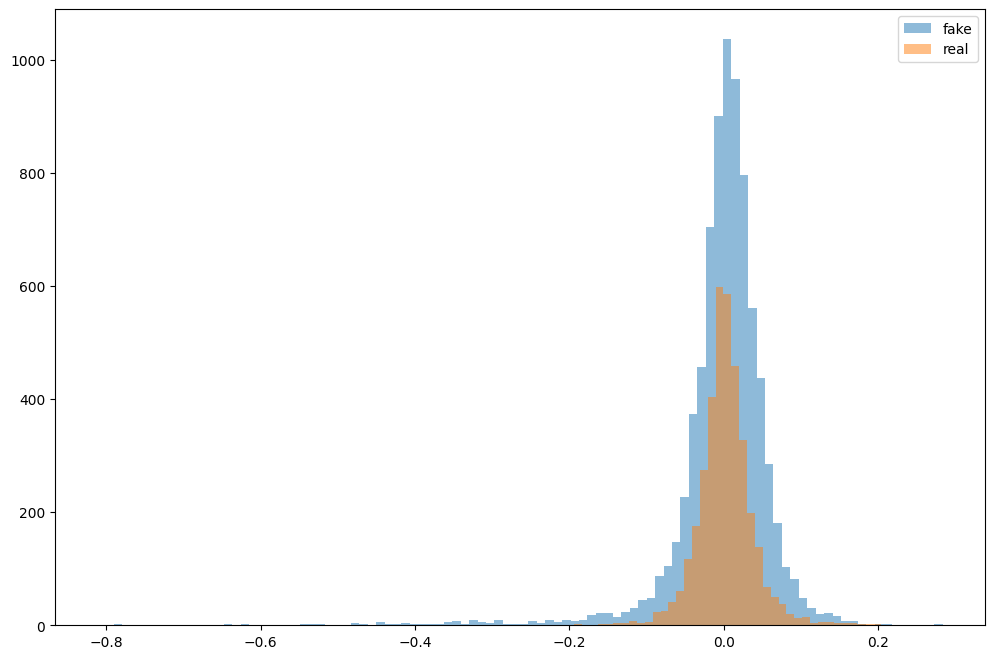

In [8]:
for i in range(10):
    plt.figure(figsize=(12, 8))
    plt.hist(r_simple_fake[:, i], bins=100, label='fake', alpha=0.5)
    plt.hist(r_log_real.iloc[:, i].apply(lambda x: np.exp(x) - 1), bins=100, label='real', alpha=0.5)
    plt.legend()
    plt.show()